In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_19_p924.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p1060.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_29_p181.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p771.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_113_p275.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_133_p912.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p1206.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_113_p247.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p361.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_

In [2]:
#setup
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [16]:
import os

base_path = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri"
print(os.listdir(base_path))


['s1', 's2']


In [20]:
import os

clean_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1"
print("Sample files:", os.listdir(clean_dir)[:10])


Sample files: ['ROIs1970_fall_s1_19_p924.png', 'ROIs1868_summer_s1_59_p1060.png', 'ROIs1970_fall_s1_29_p181.png', 'ROIs1868_summer_s1_59_p771.png', 'ROIs1970_fall_s1_113_p275.png', 'ROIs1970_fall_s1_133_p912.png', 'ROIs1868_summer_s1_59_p1206.png', 'ROIs1970_fall_s1_113_p247.png', 'ROIs1868_summer_s1_59_p361.png', 'ROIs1868_summer_s1_59_p575.png']


In [34]:
class Sentinel12Dataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.s1_dir = os.path.join(base_dir, "s1")
        self.s2_dir = os.path.join(base_dir, "s2")

        # get file lists
        s1_files = sorted(os.listdir(self.s1_dir))
        s2_files = sorted(os.listdir(self.s2_dir))

        # build matching pairs based on common prefix
        self.pairs = []
        for f in s1_files:
            key = f.replace("_s1_", "_s2_")  # replace s1 with s2
            if key in s2_files:
                self.pairs.append((f, key))

        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        s1_file, s2_file = self.pairs[idx]
        s1_path = os.path.join(self.s1_dir, s1_file)
        s2_path = os.path.join(self.s2_dir, s2_file)

        s1 = Image.open(s1_path).convert("L")
        s2 = Image.open(s2_path).convert("RGB")

        s1 = self.transform(s1)
        s2 = self.transform(s2)

        return s1, s2
base_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri"
dataset = Sentinel12Dataset(base_dir)

print("Total matched pairs:", len(dataset))

s1, s2 = dataset[0]
print("S1 shape:", s1.shape, "S2 shape:", s2.shape)


Total matched pairs: 4000
S1 shape: torch.Size([1, 128, 128]) S2 shape: torch.Size([3, 128, 128])


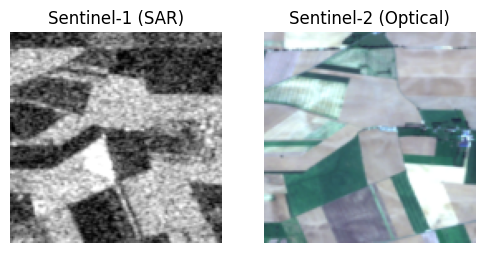

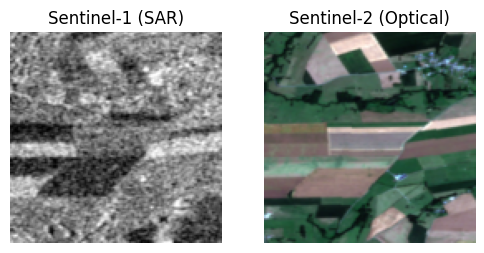

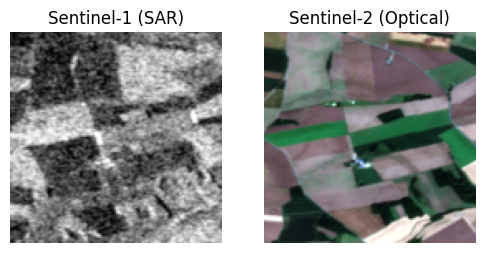

In [35]:
import matplotlib.pyplot as plt

def show_sample(dataset, idx=0):
    s1, s2 = dataset[idx]
    s1_img = s1.squeeze(0).numpy()   # [H, W]
    s2_img = s2.permute(1, 2, 0).numpy()  # [H, W, 3]

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    axes[0].imshow(s1_img, cmap="gray")
    axes[0].set_title("Sentinel-1 (SAR)")
    axes[0].axis("off")

    axes[1].imshow(s2_img)
    axes[1].set_title("Sentinel-2 (Optical)")
    axes[1].axis("off")
    plt.show()

show_sample(dataset, idx=0)
show_sample(dataset, idx=10)
show_sample(dataset, idx=50)


In [36]:
from torch.utils.data import random_split, DataLoader
full_ds = Sentinel12Dataset(base_dir)
#90/10
g = torch.Generator().manual_seed(42)
train_size = int(0.9 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=g)


batch_size = 16
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2 if use_cuda else 0, pin_memory=use_cuda
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2 if use_cuda else 0, pin_memory=use_cuda
)

len(train_ds), len(val_ds)


(3600, 400)

In [41]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): 
        return self.net(x)

class UNetDenoiseRobust(nn.Module):

    def __init__(self, in_channels=1, out_channels=3, feats=(64,128,256)):
        super().__init__()
        f1, f2, f3 = feats

        # encoder
        self.enc1 = ConvBlock(in_channels, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck = ConvBlock(f3, f3*2)

        # decoder
        self.up3 = nn.ConvTranspose2d(f3*2, f3, 2, 2)
        self.dec3 = ConvBlock(f3*2, f3)
        self.up2 = nn.ConvTranspose2d(f3, f2, 2, 2)
        self.dec2 = ConvBlock(f2*2, f2)
        self.up1 = nn.ConvTranspose2d(f2, f1, 2, 2)
        self.dec1 = ConvBlock(f1*2, f1)

        self.final = nn.Conv2d(f1, out_channels, 1)

    def _align_and_cat(self, upsampled, skip):
        if upsampled.shape[2:] != skip.shape[2:]:
            upsampled = F.interpolate(upsampled, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return torch.cat([upsampled, skip], dim=1)

    def forward(self, x):
        e1 = self.enc1(x)                 
        e2 = self.enc2(self.pool1(e1))      
        e3 = self.enc3(self.pool2(e2))      

        b  = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)                   
        d3 = self._align_and_cat(d3, e3)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = self._align_and_cat(d2, e2)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = self._align_and_cat(d1, e1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        # if you trained with targets in [0,1], keep sigmoid; otherwise remove
        return torch.sigmoid(out)


def test_model_forward():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNetDenoiseRobust(in_channels=1, out_channels=3, feats=(64,128,256)).to(device)
    model.eval()
    print("Dummy forward test (batch 1, 1x128x128)...")
    x = torch.randn(1,1,128,128).to(device)
    with torch.no_grad():
        y = model(x)
    print("  -> output shape:", y.shape) 

    try:
        
        s1, s2 = dataset[0] 
        
        s1_batch = s1.unsqueeze(0).to(device)  # [1,1,H,W]
        print("Real sample forward test (using dataset[0])...")
        with torch.no_grad():
            y2 = model(s1_batch)
        print("  -> output shape (real sample):", y2.shape, "target shape:", s2.unsqueeze(0).shape)
    except NameError:
        print("Note: 'dataset' variable not found in scope — skip real sample test.")
    except Exception as ex:
        print("Real sample forward failed with exception:", repr(ex))

# tests
test_model_forward()


Dummy forward test (batch 1, 1x128x128)...
  -> output shape: torch.Size([1, 3, 128, 128])
Real sample forward test (using dataset[0])...
  -> output shape (real sample): torch.Size([1, 3, 128, 128]) target shape: torch.Size([1, 3, 128, 128])


In [42]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetDenoiseRobust(in_channels=1, out_channels=3).to(device)

criterion = nn.MSELoss()  # L2 loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Training loop

epochs = 5  
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for s1, s2 in train_loader:
        s1, s2 = s1.to(device), s2.to(device)   

        optimizer.zero_grad()
        outputs = model(s1)                     # predict s2
        loss = criterion(outputs, s2)           # compare to ground truth
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * s1.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.6f}")


Epoch [1/5] Loss: 0.039546
Epoch [2/5] Loss: 0.036796
Epoch [3/5] Loss: 0.035143
Epoch [4/5] Loss: 0.033687
Epoch [5/5] Loss: 0.033099


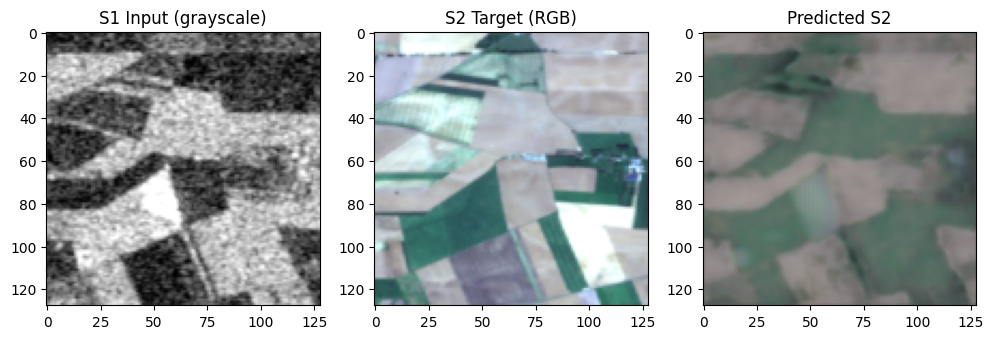

In [43]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    s1, s2 = dataset[0]
    s1_in = s1.unsqueeze(0).to(device)   # add batch
    pred = model(s1_in).cpu().squeeze(0) # remove batch


fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(s1.squeeze(0), cmap="gray")
axs[0].set_title("S1 Input (grayscale)")
axs[1].imshow(s2.permute(1,2,0))
axs[1].set_title("S2 Target (RGB)")
axs[2].imshow(pred.permute(1,2,0))
axs[2].set_title("Predicted S2")
plt.show()
